In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import shutil

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image

In [2]:
df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv')
df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [36]:
# Create a new column called 'path' that contains the path to the image files
df['path'] = df['id'].map(lambda x: x + '.tif')

# Convert label into string for categorical processing
df['label'] = df['label'].apply(lambda x: 'True' if x == 1 else 'False')
df.head()

,id,label,path
0,f38a6374c348f90b587e046aac6079959adf3835,False,f38a6374c348f90b587e046aac6079959adf3835.tif
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,True,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
2,755db6279dae599ebb4d39a9123cce439965282d,False,755db6279dae599ebb4d39a9123cce439965282d.tif
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,False,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
4,068aba587a4950175d04c680d38943fd488d6a9d,False,068aba587a4950175d04c680d38943fd488d6a9d.tif


In [3]:
datagen = ImageDataGenerator(
    rescale=1./255, 
    horizontal_flip=True, 
    vertical_flip=True, 
    rotation_range=90, 
    zoom_range=0.2, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.05, 
    channel_shift_range=0.1
    )

In [37]:
# Split df into 2 dataframes, for train and validation purpose
train_df, validation_df = train_test_split(df, test_size=0.2, random_state=420)

# Split validation_df into 2 dataframes, for validation and test purpose
validation_df, test_df = train_test_split(validation_df, test_size=0.5, random_state=420)

train_df.head()

,id,label,path
202438,3c8038b8d09eebd0c4179091705a2abb6e2f72e5,False,3c8038b8d09eebd0c4179091705a2abb6e2f72e5.tif
31421,031f323afd00d657f7e55ac9e723c00fd5138d1c,True,031f323afd00d657f7e55ac9e723c00fd5138d1c.tif
185941,7e09919a476bea76138aa80f9e7eed25c1007842,False,7e09919a476bea76138aa80f9e7eed25c1007842.tif
132968,4f69a6497919e6e78114d55f55d9c039d50025c2,False,4f69a6497919e6e78114d55f55d9c039d50025c2.tif
113495,14ab98e5da7125a1396109f9e42edebc8d1a2ea8,False,14ab98e5da7125a1396109f9e42edebc8d1a2ea8.tif


In [67]:
# Create train, validation and test generator, using flow from dataframe

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df, 
    directory='histopathologic-cancer-detection/train', 
    x_col='path', 
    y_col='label', 
    target_size=(96, 96), 
    class_mode='categorical', 
    batch_size=64,
    shuffle=True
    )

validation_generator = datagen.flow_from_dataframe(
    dataframe=validation_df, 
    directory='histopathologic-cancer-detection/train', 
    x_col='path', 
    y_col='label', 
    target_size=(96, 96), 
    class_mode='categorical', 
    batch_size=64,
    shuffle=True
    )

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df, 
    directory='histopathologic-cancer-detection/train', 
    x_col='path', 
    y_col='label', 
    target_size=(96, 96), 
    class_mode='categorical', 
    batch_size=64,
    shuffle=False
    )

Found 176020 validated image filenames belonging to 2 classes.
Found 22002 validated image filenames belonging to 2 classes.
Found 22003 validated image filenames belonging to 2 classes.


In [39]:
# Show class labels from train generator
train_generator.class_indices

{'False': 0, 'True': 1}

In [18]:
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (96, 96, 3)))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(Conv2D(first_filters, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(Conv2D(second_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(Conv2D(third_filters, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(2, activation = "softmax"))

model.summary()

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1740899916.965212    8503 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5632 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 90, 90, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 41, 41, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 39, 39, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 13, 13, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,661,186 (6.34 MB)

 Trainable params: 1,661,186 (6.34 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy'])

In [44]:
checkpoint = ModelCheckpoint('model.h5', monitor='val_acc', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=20)

Epoch 1/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7991 - loss: 0.4518

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2751/2751 ━━━━━━━━━━━━━━━━━━━━ 585s 212ms/step - accuracy: 0.7991 - loss: 0.4517 - val_accuracy: 0.8214 - val_loss: 0.4023
Epoch 2/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 530s 193ms/step - accuracy: 0.8326 - loss: 0.3880 - val_accuracy: 0.8474 - val_loss: 0.3655
Epoch 3/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 610s 222ms/step - accuracy: 0.8448 - loss: 0.3610 - val_accuracy: 0.8598 - val_loss: 0.3308
Epoch 4/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 456s 166ms/step - accuracy: 0.8518 - loss: 0.3490 - val_accuracy: 0.8546 - val_loss: 0.3372
Epoch 5/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 437s 159ms/step - accuracy: 0.8563 - loss: 0.3398 - val_accuracy: 0.8696 - val_loss: 0.3159
Epoch 6/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 432s 157ms/step - accuracy: 0.8632 - loss: 0.3264 - val_accuracy: 0.8745 - val_loss: 0.3030
Epoch 7/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 412s 150ms/step - accuracy: 0.8659 - loss: 0.3224 - val_accuracy: 0.8627 - val_loss: 0.3136
Epoch 8/20
2751/2751 ━━━━━━━━━━━━━━━━━━━━ 408s 148ms/step - accuracy: 0.8

In [49]:
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

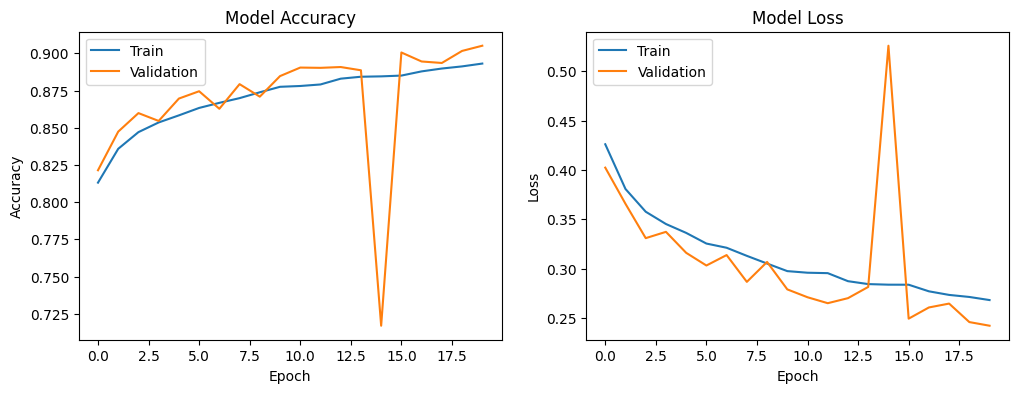

In [50]:
plot_training_history(history)

In [68]:
predictions = model.predict(test_generator, verbose=1, steps=len(test_generator))

/home/tc/Github/MSDS-deep-learning/env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


227/344 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step

KeyboardInterrupt: 

In [ ]:
df_preds = pd.DataFrame(predictions, columns=['False', 'True'])

df_preds.head()

,False,True
0,3.420014e-08,1.000000
1,9.988175e-01,0.001183
2,9.973086e-01,0.002691
3,1.365020e-03,0.998635
4,9.206976e-01,0.079302


In [69]:
# Use predicted probabilities for the positive class
y_pred = predictions[:, 1]  # Assuming second column is the positive class

# Or use predict_generator if you prefer
y_pred = model.predict(test_generator, verbose=1, steps=len(test_generator))[:, 1]

344/344 ━━━━━━━━━━━━━━━━━━━━ 37s 108ms/step


In [70]:
y_true = test_generator.classes
roc_auc_score(y_true, y_pred)

np.float64(0.960166554232707)

NameError: name 'fpr_keras' is not defined

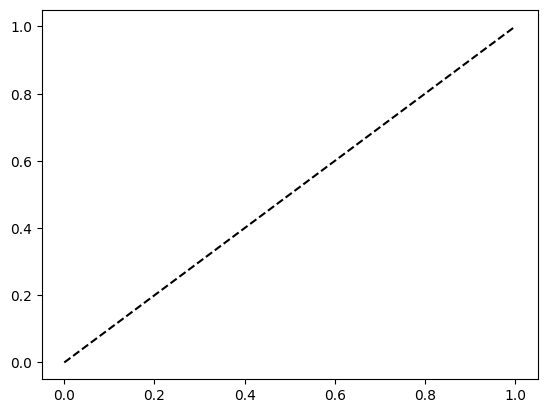

In [62]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()